In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gcsfs
import zarr
import xarray

import ftplib
import os
from io import BytesIO
import xarray as xr

demo_start_time = '2025-11-27'
demo_end_time = '2025-12-10'

def upload_to_ftp(ftp_host, ftp_user, ftp_password, local_file_path, ftp_directory):
    """
    将文件上传到FTP服务器
    
    Parameters:
    -----------
    ftp_host : str
        FTP服务器地址
    ftp_user : str
        FTP用户名
    ftp_password : str
        FTP密码
    local_file_path : str
        本地文件路径
    ftp_directory : str
        FTP目标目录
    """
    try:
        # 连接到FTP服务器
        ftp = ftplib.FTP(ftp_host)
        ftp.login(user=ftp_user, passwd=ftp_password)
        
        # 切换到目标目录
        ftp.cwd(ftp_directory)
        
        # 获取文件名
        filename = os.path.basename(local_file_path)
        
        # 上传文件
        with open(local_file_path, 'rb') as file:
            ftp.storbinary(f'STOR {filename}', file)
        
        print(f"File {filename} uploaded successfully to {ftp_directory}")
        
        # 关闭FTP连接
        ftp.quit()
        return True
        
    except Exception as e:
        print(f"Error uploading file: {e}")
        return False
    


import rioxarray
from ftplib import FTP
import tempfile
import os

# FTP连接信息
ftp_host = "10.168.39.193"
ftp_user = "Longhao_WANG" 
ftp_password = "123456789"

# 连接FTP并下载文件到临时目录
with FTP(ftp_host) as ftp:
    ftp.login(ftp_user, ftp_password)
    
    # 远程文件路径
    remote_paths = [
        '/Projects/data_NRT/S2S/Control forecast/P/P_' + demo_end_time + '_weekly.tif',
        '/Projects/data_NRT/S2S/Control forecast/T/Tdew_' + demo_end_time + '_weekly.tif',
        '/Projects/data_NRT/S2S/Control forecast/T/Tavg_' + demo_end_time + '_weekly.tif'
    ]
    
    temp_paths = []
    for remote_path in remote_paths:
        # 创建临时文件
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            # 下载文件
            ftp.retrbinary(f'RETR {remote_path}', temp_file.write)
            temp_paths.append(temp_file.name)

# 使用rioxarray读取数据        
data_prcp = rioxarray.open_rasterio(temp_paths[0])
data_d2m = rioxarray.open_rasterio(temp_paths[1]) 
data_t2m = rioxarray.open_rasterio(temp_paths[2])
import xarray as xr
import pandas as pd
import numpy as np

# Create time coordinates for 6 weeks starting from demo_end_time
time_coords = pd.date_range(start=demo_end_time, periods=6, freq='7D')

# Reshape data into standard format
data_prcp_reshaped = data_prcp.values.reshape(6, data_prcp.y.size, data_prcp.x.size)
data_d2m_reshaped = data_d2m.values.reshape(6, data_d2m.y.size, data_d2m.x.size)
data_t2m_reshaped = data_t2m.values.reshape(6, data_t2m.y.size, data_t2m.x.size)

# Create new dataset with standard dimensions
standard_data = xr.Dataset(
    data_vars={
        'total_precipitation': (('time', 'latitude', 'longitude'), 
            data_prcp_reshaped),
        '2m_dewpoint_temperature': (('time', 'latitude', 'longitude'), 
            data_d2m_reshaped),
        '2m_temperature': (('time', 'latitude', 'longitude'), 
            data_t2m_reshaped)
    },
    coords={
        'time': time_coords,
        'latitude': data_prcp.y.values,  # Use .values to get just the coordinate values
        'longitude': data_prcp.x.values   # Use .values to get just the coordinate values
    }
)

# 计算潜在蒸散发
t2m_celsius = standard_data['2m_temperature'].values
d2m_celsius = standard_data['2m_dewpoint_temperature'].values

# 计算饱和水汽压和实际水汽压
es = 0.618 * np.exp(17.27 * t2m_celsius / (t2m_celsius + 237.3))
ea = 0.618 * np.exp(17.27 * d2m_celsius / (d2m_celsius + 237.3))

# 计算比率，避免除零错误
ratio_ea_es = np.full_like(t2m_celsius, np.nan)
valid_es_mask = es > 1e-9
ratio_ea_es[valid_es_mask] = ea[valid_es_mask] / es[valid_es_mask]
ratio_ea_es = np.clip(ratio_ea_es, None, 1.0)

# 计算PET
pet = 4.5 * np.power((1 + t2m_celsius / 25.0), 2) * (1 - ratio_ea_es)
pet = np.maximum(pet, 0)

# 添加到数据集
standard_data['potential_evapotranspiration'] = (('time', 'latitude', 'longitude'), pet)

import xarray as xr
import numpy as np

# Open the dataset
temp = xr.open_dataset('E:/data/temp.nc', engine='netcdf4')
climate = xr.open_dataset('E:/data/climate_variables_2000_2023_weekly.nc')

import xarray as xr
import pandas as pd

demo_start = (pd.to_datetime(demo_start_time) - pd.Timedelta(days=7)).strftime('%Y-%m-%d')

data_inner_steps = 24
ds_surface = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    consolidated=True
)[['large_scale_rain_rate', 'convective_rain_rate', '2m_dewpoint_temperature', '2m_temperature']]
surface_ds_former = ds_surface.sel(time=slice(demo_start, demo_end_time, data_inner_steps))
surface_ds_former.load()

# week1 和 week2 从存储桶读取
week1_data = surface_ds_former.isel(time=slice(0, 7))    # 第1-7天
week2_data = surface_ds_former.isel(time=slice(7, 14))   # 第8-14天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')

# week3 从网盘读取 MSWX tif 数据
week3_start = (pd.to_datetime(demo_end_time) - pd.Timedelta(days=6)).strftime('%Y-%m-%d')
week3_dates = pd.date_range(start=week3_start, end=demo_end_time, freq='D')

print(f"\n{'='*60}")
print(f"Reading week3 data from NRT disk: {week3_start} to {demo_end_time}")
print(f"{'='*60}")

# 从FTP读取week3的7天数据
week3_t2m_list = []
week3_prcp_list = []
week3_rh_list = []

with FTP(ftp_host) as ftp:
    ftp.login(ftp_user, ftp_password)

    temp_files_to_delete = []

    for date in week3_dates:
        date_str = date.strftime('%Y-%m-%d')

        # 读取气温 - 单位: 摄氏度 (已验证)
        temp_remote = f'/Projects/data_NRT/MSWX/tif/air temperature-{date_str}.tif'
        with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as temp_file:
            ftp.retrbinary(f'RETR {temp_remote}', temp_file.write)
            temp_path = temp_file.name
            temp_files_to_delete.append(temp_path)
        # 将数据加载到内存中
        t2m_data = rioxarray.open_rasterio(temp_path).squeeze().load()
        week3_t2m_list.append(t2m_data)

        # 读取降水 - 单位: mm/day (已验证)
        prcp_remote = f'/Projects/data_NRT/MSWX/tif/MSWEP_{date_str}.tif'
        with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as temp_file:
            ftp.retrbinary(f'RETR {prcp_remote}', temp_file.write)
            temp_path = temp_file.name
            temp_files_to_delete.append(temp_path)
        # 将数据加载到内存中
        prcp_data = rioxarray.open_rasterio(temp_path).squeeze().load()
        week3_prcp_list.append(prcp_data)

        # 读取相对湿度 - 单位: 百分比 0-100 (已验证)
        rh_remote = f'/Projects/data_NRT/MSWX/tif/relative humidity-{date_str}.tif'
        with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as temp_file:
            ftp.retrbinary(f'RETR {rh_remote}', temp_file.write)
            temp_path = temp_file.name
            temp_files_to_delete.append(temp_path)
        # 将数据加载到内存中
        rh_data = rioxarray.open_rasterio(temp_path).squeeze().load()
        week3_rh_list.append(rh_data)

        print(f"  Loaded {date_str}")



# 将7天数据堆叠并计算周平均
week3_t2m = xr.concat(week3_t2m_list, dim='time').mean(dim='time')
week3_prcp = xr.concat(week3_prcp_list, dim='time').mean(dim='time')
week3_rh = xr.concat(week3_rh_list, dim='time').mean(dim='time')

print(f"\nWeek3 MSWX data loaded:")
print(f"  - Resolution: 0.1deg x 0.1deg ({week3_t2m.y.size} x {week3_t2m.x.size})")
print(f"  - Temperature: {week3_t2m.values.mean():.2f} C")
print(f"  - Precipitation: {week3_prcp.values.mean():.2f} mm/day")
print(f"  - Relative Humidity: {week3_rh.values.mean():.2f}%")

# 通过相对湿度计算露点温度
# RH = (ea / es) * 100, where ea is actual vapor pressure, es is saturation vapor pressure
t2m_celsius = week3_t2m.values
rh_percent = week3_rh.values

# 计算饱和水汽压 (kPa)
es = 0.618 * np.exp(17.27 * t2m_celsius / (t2m_celsius + 237.3))

# 计算实际水汽压
ea = es * rh_percent / 100.0

# 从实际水汽压反算露点温度
# ea = 0.618 * exp(17.27 * Td / (Td + 237.3))
# 重排得: Td = 237.3 * ln(ea/0.618) / (17.27 - ln(ea/0.618))
ea_safe = np.maximum(ea, 0.001)  # 避免负值或零
ln_term = np.log(ea_safe / 0.618)
dewpoint_celsius = 237.3 * ln_term / (17.27 - ln_term)

print(f"  - Calculated dewpoint: {dewpoint_celsius.mean():.2f} C")

# 统一空间分辨率: 从0.1deg粗化到0.25deg (与ERA5一致)
# 获取目标坐标（从week1_data的ERA5网格）
target_lat = week1_data.latitude.values
target_lon = week1_data.longitude.values

print(f"\nResampling to ERA5 grid (0.25deg):")
print(f"  - Target grid: {len(target_lat)} x {len(target_lon)}")

# 创建xarray DataArray以便使用插值
# MSWX: 纬度从北到南 (89.95 to -89.95), 经度从西到东 (-179.95 to 179.95)
# ERA5: 纬度从北到南 (90 to -90), 经度从西到东 (0 to 359.75)
week3_t2m_da = xr.DataArray(
    week3_t2m.values,
    coords={'latitude': week3_t2m.y.values, 'longitude': week3_t2m.x.values},
    dims=['latitude', 'longitude']
)

week3_prcp_da = xr.DataArray(
    week3_prcp.values,
    coords={'latitude': week3_prcp.y.values, 'longitude': week3_prcp.x.values},
    dims=['latitude', 'longitude']
)

week3_d2m_da = xr.DataArray(
    dewpoint_celsius,
    coords={'latitude': week3_t2m.y.values, 'longitude': week3_t2m.x.values},
    dims=['latitude', 'longitude']
)

# 使用双线性插值到ERA5网格
week3_t2m_interp = week3_t2m_da.interp(
    latitude=target_lat,
    longitude=target_lon,
    method='linear'
)

week3_prcp_interp = week3_prcp_da.interp(
    latitude=target_lat,
    longitude=target_lon,
    method='linear'
)

week3_d2m_interp = week3_d2m_da.interp(
    latitude=target_lat,
    longitude=target_lon,
    method='linear'
)

print(f"  - Interpolation complete")

# 创建week3_mean数据集（与week1_mean, week2_mean格式一致）
# 重要：将温度从摄氏度转换为开尔文，保持与ERA5格式一致
# MSWX数据是摄氏度，ERA5数据是开尔文，需要统一为开尔文
# 单位转换: mm/day -> m/hr (ERA5格式)
# mm/day = mm/day * (1 m / 1000 mm) * (1 day / 24 hr) = m/hr
week3_mean = xr.Dataset({
    '2m_temperature': (['latitude', 'longitude'], week3_t2m_interp.values + 273.15),  # C -> K
    '2m_dewpoint_temperature': (['latitude', 'longitude'], week3_d2m_interp.values + 273.15),  # C -> K
    # 将总降水分为large_scale和convective，各占50%
    'large_scale_rain_rate': (['latitude', 'longitude'], week3_prcp_interp.values * 0.5 / 24.0 / 1000.0),
    'convective_rain_rate': (['latitude', 'longitude'], week3_prcp_interp.values * 0.5 / 24.0 / 1000.0)
}, coords={
    'latitude': target_lat,
    'longitude': target_lon
})

print(f"  - Temperature converted: C -> K (mean: {(week3_t2m_interp.values + 273.15).mean():.2f} K)")

print(f"\nWeek3 mean dataset created:")
print(f"  - Grid: {len(target_lat)} x {len(target_lon)}")
print(f"  - Variables: {list(week3_mean.data_vars)}")
print(f"{'='*60}\n")

# 合并为一个新的数据集，包含三周的平均值
ds_former_means = xr.concat([week1_mean, week2_mean, week3_mean],
                         dim=pd.DatetimeIndex([
                             pd.to_datetime(week1_data.time.values[0]),
                             pd.to_datetime(week2_data.time.values[0]),
                             pd.to_datetime(week3_dates[0])
                         ], name='time'))

print(f"Combined 3-week historical data:")
print(f"  - Time coverage: {ds_former_means.time.values}")
print(f"  - Shape: {ds_former_means['2m_temperature'].shape}")



# 加载预测数据集
import xarray as xr
from datetime import datetime, timedelta

# 计算文件名的起止时间
end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
start_date = end_date + timedelta(days=1)
end_date = end_date + timedelta(weeks=6)

# 加载预测数据集
import xarray as xr
surface_ds = ds_former_means

# 处理温度数据 - 从开尔文转换为摄氏度
surface_ds['2m_temperature'] = surface_ds['2m_temperature'] - 273.15
surface_ds['2m_dewpoint_temperature'] = surface_ds['2m_dewpoint_temperature'] - 273.15

# 处理降水数据 - 从 m/hr 转换为 mm/day
precip_vars = ['large_scale_rain_rate', 'convective_rain_rate']
m_hr_to_mm_day_factor = 24.0 * 1000.0
for var in precip_vars:
    if var in surface_ds:
        surface_ds[var] = surface_ds[var].where(surface_ds[var] >= 0, 0)
        surface_ds[var] = surface_ds[var] * m_hr_to_mm_day_factor



surface_ds['total_precipitation'] = surface_ds['large_scale_rain_rate'] + surface_ds['convective_rain_rate']


t2m_celsius = surface_ds['2m_temperature'].values
d2m_celsius = surface_ds['2m_dewpoint_temperature'].values

# 计算饱和水汽压和实际水汽压
es = 0.618 * np.exp(17.27 * t2m_celsius / (t2m_celsius + 237.3))
ea = 0.618 * np.exp(17.27 * d2m_celsius / (d2m_celsius + 237.3))

# 计算比率，避免除零错误
ratio_ea_es = np.full_like(t2m_celsius, np.nan)
valid_es_mask = es > 1e-9
ratio_ea_es[valid_es_mask] = ea[valid_es_mask] / es[valid_es_mask]
ratio_ea_es = np.clip(ratio_ea_es, None, 1.0)

# 计算PET
pet = 4.5 * np.power((1 + t2m_celsius / 25.0), 2) * (1 - ratio_ea_es)
pet = np.maximum(pet, 0)

# 添加到数据集
surface_ds['potential_evapotranspiration'] = (('time', 'latitude', 'longitude'), pet)

# 使用列表语法正确提取多个变量
ds_sub = surface_ds[['total_precipitation', 'potential_evapotranspiration', '2m_temperature']]

# 6x6变粗平均采样
ds_sub_coarsened = ds_sub.coarsen(latitude=6, longitude=6, boundary='trim').mean()

# 截取到指定的经纬度范围
ds_sub_cropped = ds_sub_coarsened.sel(
    latitude=slice(54.0, 15.0),
    longitude=slice(70.5, 139.5)
)

# 将ds_sub_cropped的网格插值到与standard_data一致的网格
# 定义目标网格坐标（与standard_data一致）
target_lat = np.arange(54.0, 14.5, -1.5)  # 从54.0到15.0，步长1.5
target_lon = np.arange(70.5, 140.0, 1.5)  # 从70.5到139.5，步长1.5

# 使用xarray的interp方法进行双线性插值
ds_sub_cropped = ds_sub_cropped.interp(
    latitude=target_lat,
    longitude=target_lon,
    method='linear'
)

combined_ds = xr.concat(
    [ds_sub_cropped, standard_data[['total_precipitation', 'potential_evapotranspiration', '2m_temperature']]],
    dim='time'
)
# 对climate数据进行6x6变粗平均采样
climate_coarsened = climate.coarsen(lat=6, lon=6, boundary='trim').mean()

# 截取到指定的经纬度范围
climate_cropped = climate_coarsened.sel(
    lat=slice(54.0, 15.0),
    lon=slice(70.5, 139.5)
)

# 将climate_cropped的网格插值到与standard_data一致的网格
# 定义目标网格坐标（与standard_data一致）
target_lat = np.arange(54.0, 14.5, -1.5)  # 从54.0到15.0，步长1.5
target_lon = np.arange(70.5, 140.0, 1.5)  # 从70.5到139.5，步长1.5

# 使用xarray的interp方法进行双线性插值
climate_cropped = climate_cropped.interp(
    lat=target_lat,
    lon=target_lon,
    method='linear'
)

# 3. 自定义函数计算周号（按照固定的周定义：1-7日为1周，8-14日为2周...）
def get_week_of_year(date):
    # 计算一年中的周数，第一周为1-7日
    day_of_year = date.dt.dayofyear
    return ((day_of_year - 1) // 7) + 1

# 计算ECMWF的降水距平百分比
precip_hist = climate_cropped['tp']
precip_pred = standard_data['total_precipitation'].rename({'latitude': 'lat', 'longitude': 'lon'})
precip_pred = precip_pred.sortby('lat', ascending=False).sortby('lon')
precip_pred = precip_pred.interp(
    lat=precip_hist['lat'],
    lon=precip_hist['lon'],
    method='linear'
)

hist_week_numbers = get_week_of_year(precip_hist['time'])
pred_week_numbers = get_week_of_year(precip_pred['time'])

precip_anomaly_percent_list = []

for i, _ in enumerate(precip_pred['time']):
    curr_week_num = pred_week_numbers.isel(time=i).item()
    hist_precip_same_week = precip_hist.where(hist_week_numbers == curr_week_num, drop=True)
    hist_mean = hist_precip_same_week.mean(dim='time')
    curr_precip = precip_pred.isel(time=i)
    precip_anomaly_percent = (curr_precip - hist_mean * 0.5) / (hist_mean * 0.5) * 100
    precip_anomaly_percent = precip_anomaly_percent.clip(-200, 200)
    precip_anomaly_percent_list.append(precip_anomaly_percent)

precip_anomaly_percent = xr.concat(precip_anomaly_percent_list, dim='time')
precip_anomaly_percent = precip_anomaly_percent.assign_coords(time=precip_pred['time'])

input_end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
ec_anom_start_date = input_end_date + timedelta(days=1)
ec_anom_end_date = input_end_date + timedelta(days=6*7)
ec_prcp_anom_filename = f"EC_PrcpAnomPercent_forecast_{ec_anom_start_date.strftime('%Y-%m-%d')}_{ec_anom_end_date.strftime('%Y-%m-%d')}.nc"
ec_prcp_anom_local_file_path = os.path.join('Z:/Data/temp', ec_prcp_anom_filename)
precip_anomaly_percent.to_netcdf(ec_prcp_anom_local_file_path)



Reading week3 data from NRT disk: 2025-12-04 to 2025-12-10
  Loaded 2025-12-04
  Loaded 2025-12-05
  Loaded 2025-12-06
  Loaded 2025-12-07
  Loaded 2025-12-08
  Loaded 2025-12-09
  Loaded 2025-12-10

Week3 MSWX data loaded:
  - Resolution: 0.1deg x 0.1deg (1800 x 3600)
  - Temperature: 4.78 C
  - Precipitation: 2.18 mm/day
  - Relative Humidity: 76.17%
  - Calculated dewpoint: 0.65 C

Resampling to ERA5 grid (0.25deg):
  - Target grid: 721 x 1440
  - Interpolation complete
  - Temperature converted: C -> K (mean: nan K)

Week3 mean dataset created:
  - Grid: 721 x 1440
  - Variables: ['2m_temperature', '2m_dewpoint_temperature', 'large_scale_rain_rate', 'convective_rain_rate']

Combined 3-week historical data:
  - Time coverage: ['2025-11-20T00:00:00.000000000' '2025-11-27T00:00:00.000000000'
 '2025-12-04T00:00:00.000000000']
  - Shape: (3, 721, 1440)


警告: 时间点 2025-12-31T00:00:00.000000000 (周 53) 的历史样本数量不足: 0
警告: 时间点 2026-01-07T00:00:00.000000000 (周 1) 的历史样本数量不足: 0
警告: 时间点 2026-01-14T00:00:00.000000000 (周 2) 的历史样本数量不足: 0


Text(0.5, 1.0, 'SPEI-4 2025-12-10')

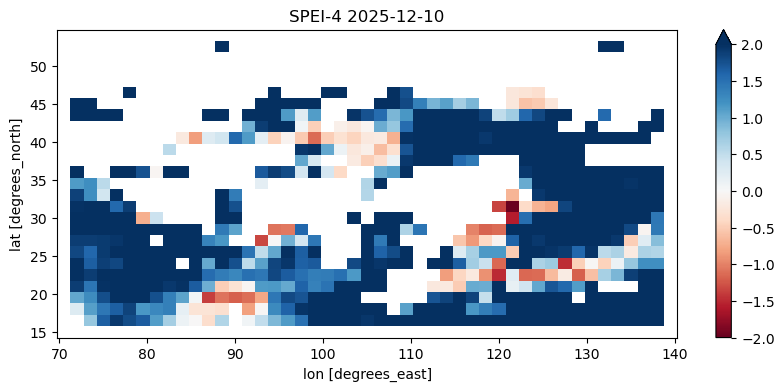

In [3]:
## 拟合函数SPEI
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_function
import pandas as pd

def calculate_pwm(series):
    n = len(series)
    if n < 3:
        return np.nan, np.nan, np.nan

    sorted_series = np.sort(series)
    F_vals = (np.arange(1, n + 1) - 0.35) / n
    one_minus_F = 1.0 - F_vals

    W0 = np.mean(sorted_series)
    W1 = np.sum(sorted_series * one_minus_F) / n
    W2 = np.sum(sorted_series * (one_minus_F**2)) / n
    
    return W0, W1, W2

def calculate_loglogistic_params(W0, W1, W2):
    if np.isnan(W0) or np.isnan(W1) or np.isnan(W2):
        return np.nan, np.nan, np.nan

    numerator_beta = (2 * W1) - W0
    denominator_beta = (6 * W1) - W0 - (6 * W2)
    
    if np.isclose(denominator_beta, 0):
        return np.nan, np.nan, np.nan 
    beta = numerator_beta / denominator_beta

    if beta <= 1.0:
        return np.nan, np.nan, np.nan

    try:
        term_gamma1 = gamma_function(1 + (1 / beta))
        term_gamma2 = gamma_function(1 - (1 / beta))
    except ValueError:
        return np.nan, np.nan, np.nan

    denominator_alpha = term_gamma1 * term_gamma2
    if np.isclose(denominator_alpha, 0):
        return np.nan, np.nan, np.nan
        
    alpha = ((W0 - (2 * W1)) * beta) / denominator_alpha
    
    if alpha <= 0:
        return np.nan, np.nan, np.nan

    gamma_param = W0 - (alpha * denominator_alpha)
    
    return alpha, beta, gamma_param

def loglogistic_cdf(x, alpha, beta, gamma_param):
    if np.isnan(alpha) or x <= gamma_param:
        return 1e-9

    term = (alpha / (x - gamma_param))**beta
    if np.isinf(term) or term > 1e18:
        return 1e-9
        
    cdf_val = 1.0 / (1.0 + term)
    return np.clip(cdf_val, 1e-9, 1.0 - 1e-9)

def cdf_to_spei(P):
    if np.isnan(P): return np.nan
    if P <= 0.0: P = 1e-9
    if P >= 1.0: P = 1.0 - 1e-9

    c0, c1, c2 = 2.515517, 0.802853, 0.010328
    d1, d2, d3 = 1.432788, 0.189269, 0.001308

    if P <= 0.5:
        w = np.sqrt(-2.0 * np.log(P))
        spei = -(w - (c0 + c1 * w + c2 * w**2) / (1 + d1 * w + d2 * w**2 + d3 * w**3))
    else:
        w = np.sqrt(-2.0 * np.log(1.0 - P))
        spei = (w - (c0 + c1 * w + c2 * w**2) / (1 + d1 * w + d2 * w**2 + d3 * w**3))
    return spei

def calculate_spei_for_pixel(historical_D_series, current_D_value):
    if np.isscalar(current_D_value):
        if np.isnan(current_D_value):
            return np.nan
    else:
        if np.all(np.isnan(current_D_value)):
            return np.nan
        
    valid_historical_D = historical_D_series[~np.isnan(historical_D_series)]
    if len(valid_historical_D) < 10:
        return np.nan

    W0, W1, W2 = calculate_pwm(valid_historical_D)
    if np.isnan(W0):
        return np.nan

    alpha, beta, gamma_p = calculate_loglogistic_params(W0, W1, W2)
    if np.isnan(alpha):
        return np.nan

    P = loglogistic_cdf(current_D_value, alpha, beta, gamma_p)
    spei_val = cdf_to_spei(P)
    
    return spei_val

# 主程序
# 1. 计算历史D
D_hist = climate_cropped['tp'] - climate_cropped['pet']

# 2. 计算ds_sub的D
D_pred = combined_ds['total_precipitation'] - combined_ds['potential_evapotranspiration']
D_pred = D_pred.rename({'latitude': 'lat', 'longitude': 'lon'})

# 只计算第4周及之后的SPEI（即预测部分的SPEI）
start_pred_idx = 3  # 从第4个时间点开始计算SPEI
spei_pred_list = []
MIN_HIST_SAMPLES = 10

# 计算预测数据的周号
pred_week_numbers = get_week_of_year(D_pred.time)
# 计算历史数据的周号
hist_week_numbers = get_week_of_year(D_hist.time)

for i in range(start_pred_idx, len(D_pred.time)):
    # 计算当前时间点及前3个时间点的D值的累积
    curr_week_accum = 0
    for j in range(4):  # 累积4周的D值
        if i-j >= 0:  # 确保索引有效
            curr_week_accum += D_pred.isel(time=i-j)
    
    # 获取当前预测点的周号
    curr_week_num = pred_week_numbers.isel(time=i).item()
    
    # 提取历史数据中相同周号的数据
    hist_4week_accum_list = []
    
    # 按年份分组处理历史数据
    hist_years = np.unique(D_hist.time.dt.year)
    
    for year in hist_years:
        # 获取该年的数据
        year_data = D_hist.where(D_hist.time.dt.year == year, drop=True)
        year_weeks = hist_week_numbers.where(D_hist.time.dt.year == year, drop=True)
        
        # 找到当前周的索引
        week_indices = np.where(year_weeks == curr_week_num)[0]
        if len(week_indices) > 0:
            week_idx = week_indices[0]
            # 确保有足够的前置周
            if week_idx >= 3:  # 需要前3周的数据
                # 累积当前周和前3周的D值
                accum_D = 0
                for j in range(4):
                    accum_D += year_data.isel(time=week_idx-j)
                hist_4week_accum_list.append(accum_D)
    
    # 合并历史累积D值
    if hist_4week_accum_list:
        hist_4week_accum = xr.concat(hist_4week_accum_list, dim='time')
    else:
        # 如果没有找到历史数据，创建空DataArray
        hist_4week_accum = xr.DataArray(
            np.zeros((0,) + D_pred.isel(time=0).shape),
            coords={'time': [], **{dim: D_pred[dim] for dim in D_pred.dims if dim != 'time'}},
            dims=D_pred.dims
        )
    
    # 计算SPEI
    if len(hist_4week_accum.time) < MIN_HIST_SAMPLES:
        print(f"警告: 时间点 {D_pred.time.values[i]} (周 {curr_week_num}) 的历史样本数量不足: {len(hist_4week_accum.time)}")
        spei_map = xr.full_like(D_pred.isel(time=i), np.nan)
    elif np.isnan(curr_week_accum).all():
        spei_map = xr.full_like(D_pred.isel(time=i), np.nan)
    else:
        # 使用vectorize=True启用numpy的向量化处理
        spei_map = xr.apply_ufunc(
            calculate_spei_for_pixel,
            hist_4week_accum,
            curr_week_accum,
            input_core_dims=[['time'], []],
            output_core_dims=[[]],
            exclude_dims=set(('time',)),
            vectorize=True,
            output_dtypes=[float],
            keep_attrs=True
        )
    
    spei_pred_list.append(spei_map)

# 合并所有时间点的SPEI结果
spei_pred = xr.concat(spei_pred_list, dim='time')
# 只保留预测部分的时间坐标
spei_pred = spei_pred.assign_coords(time=D_pred.time[start_pred_idx:])

# 5. 可视化第一个预测时间点的SPEI
plt.figure(figsize=(10,4))
spei_pred.isel(time=0).plot(vmin=-2, vmax=2, cmap='RdBu')
plt.title(f"SPEI-4 {str(spei_pred.time.values[0])[:10]}")
#plt.show()

In [5]:
D_hist

<xarray.DataArray (time: 1248, lat: 27, lon: 47)> Size: 13MB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan, -7.63956205e-03, -6.35595373e-03, ...,
         -1.86432226e-01, -1.89336007e-01,             nan],
        [            nan, -3.87337192e-02, -3.22485598e-02, ...,
         -1.49600806e-01, -1.36710724e-01,             nan],
        ...,
        [            nan, -7.44709050e+00, -7.88745543e+00, ...,
         -4.35751394e+00, -4.20254237e+00,             nan],
        [            nan, -7.55433331e+00, -8.05109437e+00, ...,
         -4.36630403e+00, -4.14661766e+00,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan, -1.92224175e-01, -1.88534399e-01, ...,
         -2.50569665e-02, -1.22001170e-02,             nan],
        [            nan, -1.57457961e-01, -1.53084343e-01, ...,
         -1.69904536e-02, -7.58016928e-03,             nan],
...
        [            nan, -6.44955746e+00, -7.10661045e+00, ...,
         -2.57319607e+00, -2.82106903e+00,             nan],
        [            nan, -6.16757808e+00, -6.91553920e+00, ...,
         -3.39882018e+00, -3.59616840e+00,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan, -1.93078569e-01, -4.22924058e-01, ...,
         -2.79235209e-02, -1.72597581e-02,             nan],
        [            nan, -2.18169722e-01, -5.33114865e-01, ...,
         -1.35884141e-02, -9.85121411e-03,             nan],
        ...,
        [            nan, -6.14816929e+00, -7.27437456e+00, ...,
         -3.71074227e+00, -3.85179715e+00,             nan],
        [            nan, -6.34397967e+00, -7.60757494e+00, ...,
         -3.77864321e+00, -3.94940854e+00,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * time     (time) datetime64[ns] 10kB 2000-01-01 2000-01-08 ... 2023-12-24
  * lat      (lat) float64 216B 54.0 52.5 51.0 49.5 48.0 ... 19.5 18.0 16.5 15.0
  * lon      (lon) float64 376B 70.5 72.0 73.5 75.0 ... 135.0 136.5 138.0 139.5

In [6]:
climate

<xarray.Dataset> Size: 16GB
Dimensions:  (time: 1248, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 10kB 2000-01-01 2000-01-08 ... 2023-12-24
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    t2m      (time, lat, lon) float32 5GB ...
    tp       (time, lat, lon) float32 5GB ...
    pet      (time, lat, lon) float32 5GB ...
Attributes:
    Conventions:   CF-1.6
    history:       2025-05-17 16:26:32 GMT Python script by user.
    description:   Weekly mean temperature, total precipitation, and potentia...
    source_files:  crr.npy, d2m.npy, lsrr.npy, t2m.npy (assumed ERA5 reanalys...